# Bike Sharing missing data Imputation with Granite Time Series TSPulse

TSPulse are compact pre-trained models specialized for various multivariate time-series analysis tasks namely classification, anomaly-detection, imputation and similarity search, open-sourced by IBM Research. With 1 Million parameters, TSPulse introduces the notion of the first-ever "tiny" pre-trained models for Time-Series tasks like classification, anomaly-detection, imputation and similarity search. TSPulse outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot setting and can easily be fine-tuned for different downstream tasks.

In this recipe, we demonstrates the usage of a pre-trained TSPulse model for time-series `imputation` task in zero-shot setting. This example makes use of the Kaggle bike sharing [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) which contains bikes rental demand with weather and seasonal information.

In zero-shot setting a pre-trained TSPulse model with all the weights frozen is used and a quick inference call can be made by passing the input data (possibly having missing values) and the pre-trained model to the `time series imputation pipeline`, which returns an output with the missing values imputed by the model.

## Imports

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [ ]:
! pip install "granite-tsfm[notebooks]==0.3.0"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ipywidgets import IntSlider, interact
from transformers import set_seed

### Imports from `tsfm_public`

In [ ]:
from tsfm_public import TimeSeriesPreprocessor
from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.time_series_imputation_pipeline import TimeSeriesImputationPipeline

In [ ]:
# # Set seed for reproducibility
SEED = 42
set_seed(SEED)

## Preparing the Data

### Download the data

We'll work with a bike sharing datasety available from the UCI Machine learning repository. This dataset includes the count of rental bikes between the years 2011 and 2012 in the Capital bike share system with the corresponding weather and seasonal information.

In [ ]:
%%bash
mkdir -p temp
BIKE_SHARING=bike+sharing+dataset.zip
URL=https://archive.ics.uci.edu/static/public/275/$BIKE_SHARING
curl -O $URL
unzip -o $BIKE_SHARING -d temp/
rm -f $BIKE_SHARING

In [ ]:
DATA_FILE_PATH = "temp/hour.csv"

In [ ]:
timestamp_column = "dteday"
target_columns = ["casual", "registered", "cnt"]


column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
}

# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Fix missing hours in original dataset date column
input_df[timestamp_column] = input_df[timestamp_column] + input_df.hr.apply(lambda x: pd.Timedelta(x, unit="hr"))

# Show the last few rows of the dataset.
input_df.tail()

fully_observed_ground_truth = input_df

### Introducing NaN values to the dataset to mimic real world missing data
We are introducing missing values in a hybrid setup i.e. both isolated points missing as well as points missing in continuous blocks of a fixed length which is a typical real-world scenario for missing data.

In [ ]:
def introduce_nans(data, target_columns, nan_fraction=0.1, block_size=8, seed=42):
    df_nan = data.copy()
    rng = np.random.default_rng(seed)

    # Get index positions of target columns
    target_col_indices = [df_nan.columns.get_loc(col) for col in target_columns]
    num_values = df_nan.shape[0] * len(target_columns)

    # Random NaNs: 3/4 of total NaNs are missing randomly (isolated missing points)
    num_nans = int(nan_fraction * num_values * (3 / 4))

    rows = rng.integers(0, df_nan.shape[0], size=num_nans)
    cols = rng.choice(target_col_indices, size=num_nans)

    for r, c in zip(rows, cols):
        df_nan.iat[r, c] = np.nan

    # Block NaNs: 1/4 of total NaNs are missing in blocks
    num_blocks = int((nan_fraction * num_values / block_size) * (1 / 4))

    for _ in range(num_blocks):
        col = rng.choice(target_col_indices)
        start_row = rng.integers(0, df_nan.shape[0] - block_size + 1)
        df_nan.iloc[start_row : start_row + block_size, col] = np.nan

    return df_nan

In [ ]:
input_df.head(100)

In [ ]:
data = introduce_nans(input_df, target_columns, nan_fraction=0.2)  # returns data having 20% missing values
data.head(100)

### Creating and traning the tsp (To preprocess the input data and perform scaling (if needed))

In [ ]:
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 0

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

tsp.train(data)  # train the tsp

## Getting the pre-trained TSPulse Model

In [ ]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=tsp.num_input_channels,
    mask_type="user",
)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

## Using Imputation Pipeline for Zero-Shot Imputation

In [ ]:
pipe = TimeSeriesImputationPipeline(model, feature_extractor=tsp, batch_size=1000, device=device)
out = pipe(data)

In [ ]:
out.head()

## Plotting the Observed and Imputed values

In [ ]:
def plot_interactive_imputation(df, fully_observed_ground_truth=None, window_size=512):
    # df = df.drop("time", axis=1)
    observed_cols = [col.removesuffix("_imputed") for col in df.columns if col.endswith("_imputed")]

    num_points = len(df)

    def plot_window(start_idx):
        end_idx = min(start_idx + window_size, num_points)
        x_range = np.arange(start_idx, end_idx, dtype=float)

        plt.figure(figsize=(15, 3 * len(observed_cols)))

        for i, base_col in enumerate(observed_cols):
            imputed_col = f"{base_col}_imputed"
            observed_vals = df[base_col].iloc[start_idx:end_idx]
            imputed_vals = df[imputed_col].iloc[start_idx:end_idx]

            pos_observed = ~observed_vals.isna()
            pos_imputed = observed_vals.isna()
            plt.subplot(len(observed_cols), 1, i + 1)

            plt.scatter(x_range[pos_imputed], imputed_vals[pos_imputed], color="red", s=5, label="Imputed")

            if fully_observed_ground_truth is not None:
                full_vals = fully_observed_ground_truth[base_col].iloc[start_idx:end_idx]
                plt.plot(x_range, full_vals, color="blue", linewidth=2, label="Ground_Truth")  # actual ground truth
                y_min = np.min(full_vals)
                y_mask = np.full(np.sum(pos_imputed), y_min)
                plt.scatter(
                    x_range[pos_imputed], y_mask, color="green", s=3, label="missing data positions"
                )  # positions where model has imputed the missing values.
            else:
                plt.plot(
                    x_range[pos_observed], observed_vals[pos_observed], color="blue", linewidth=2, label="Observed"
                )  # Plot the data with missing values with "linear interpolation" in the plot at missing positions.
                y_min = np.min(observed_vals)
                y_mask = np.full(np.sum(pos_imputed), y_min)
                plt.scatter(
                    x_range[pos_imputed], y_mask, color="green", s=3, label="missing data positions"
                )  # positions where model has imputed the missing values.

            plt.title(f"Channel: {base_col}")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("Plotting static plot for a random window")
    plot_window(15504)  # Plotting static plot for a random window

    interact(
        plot_window,
        start_idx=IntSlider(
            value=0,
            min=0,
            max=max(0, num_points - window_size),
            step=1,
            description="Start Index",
            continuous_update=False,
        ),
    )

Plotting static plot for a random window


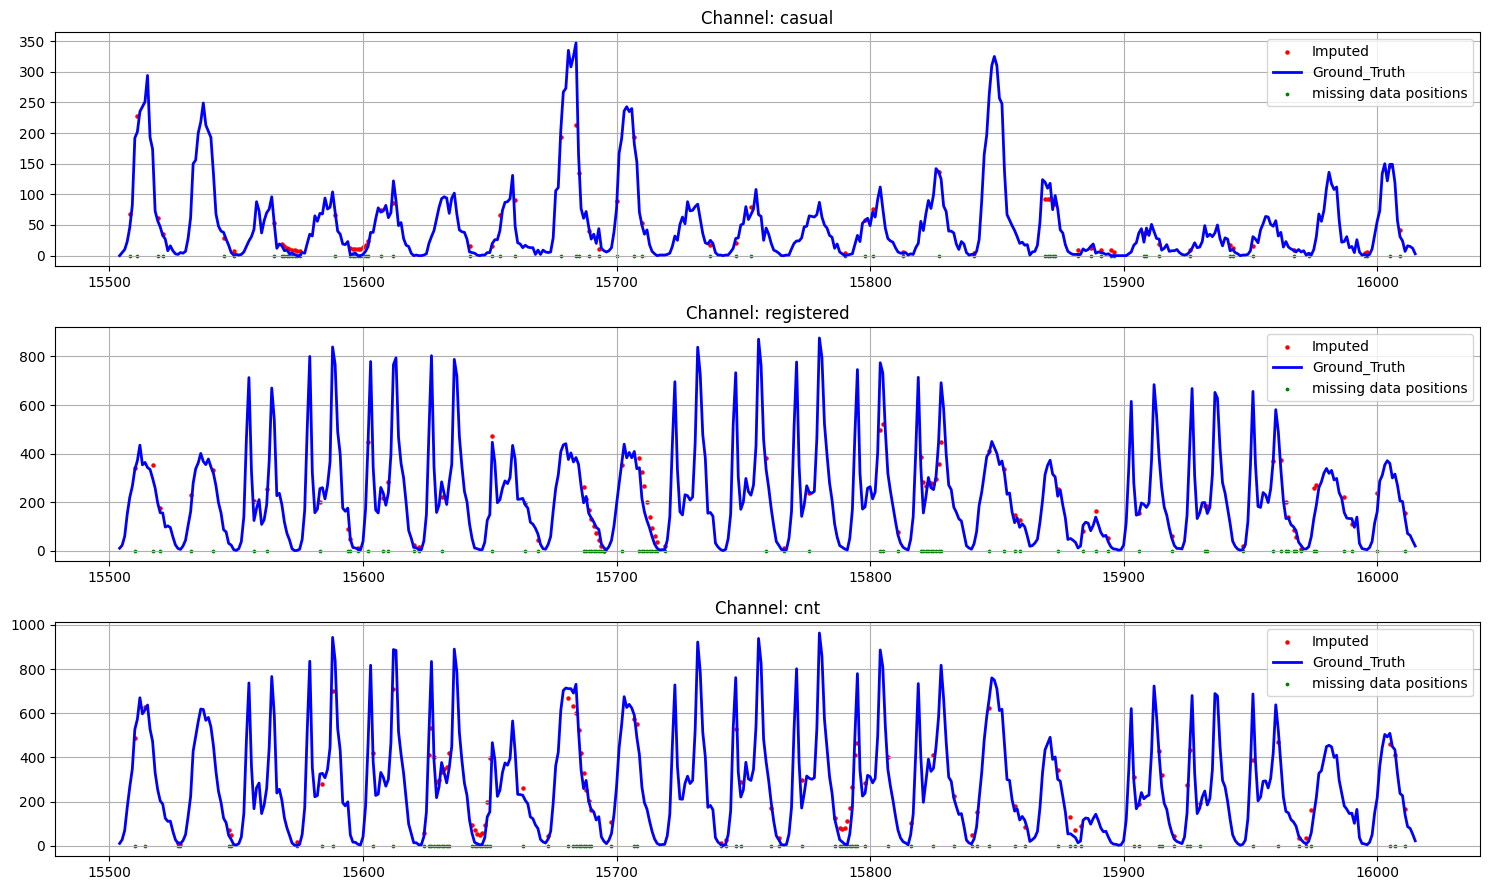

interactive(children=(IntSlider(value=0, continuous_update=False, description='Start Index', max=16867), Outpu…

In [ ]:
plot_interactive_imputation(out, fully_observed_ground_truth)

## Evaluate the Model

Evaluate the zero-shot performance of the model on the dataset.

In [ ]:
def custom_metric(actual, missing_df, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = actual.to_numpy(dtype=float)
    p = prediction.to_numpy(dtype=float)

    missing_positions = np.isnan(missing_df)

    mse = np.mean(np.square(a[missing_positions] - p[missing_positions]))
    mae = np.mean(np.abs(a[missing_positions] - p[missing_positions]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )

In [ ]:
ground_truth = fully_observed_ground_truth[target_columns]  # original df having no missing values
ground_truth_with_missing_data = out[target_columns]  # df having missing values

imputed_columns = [f"{col}_imputed" for col in target_columns]
imputed_df = out[imputed_columns]  # df having imputed values at the missing data positions

custom_metric(ground_truth, ground_truth_with_missing_data, imputed_df, "zero-shot imputation")

,zero-shot imputation
mean_squared_error,2274.490079
root_mean_squared_error,47.691614
mean_absolute_error,27.568185
